# FYP Project 2 Group G

### Research Question
[the question]

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import Config
import os, sys
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import skimage.io as sk
from skimage import morphology
from skimage.color import rgb2gray
from statsmodels.robust import mad
from PIL import Image
import ptitprince as pt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


### Dataframes

In [27]:
df = pd.read_csv(Config.features_path) #the main dataframe

mel_df = pd.read_csv(Config.example_ground_truth_path)
df['melanoma'] = mel_df['melanoma']

## Task 0 - exploring the data 
In this task, we investigated the data provided by our teacher - we looked for missing values in .csv files as well as got familiar with the data using the df.describe() function.

In [3]:
#getting the shape of df
print(f'shape of the main df: {df.shape}')

#looking for missing data
print(f'Are there any missing values in the dataset? {df.isna().any().any()}')

#getting the diagnosis types
print('')
print(f'The diagnosis types: {mel_df.columns[1:]}')

shape of the main df: (150, 4)
Are there any missing values in the dataset? False

The diagnosis types: Index(['melanoma', 'seborrheic_keratosis'], dtype='object')


In [4]:
df.describe()

,area,perimeter,melanoma
count,1.500000e+02,150.00000,150.00000
mean,3.114134e+06,5570.36000,0.20000
std,5.897570e+06,5294.59662,0.40134
min,3.294400e+04,642.00000,0.00000
25%,2.329922e+05,2014.50000,0.00000
50%,6.223165e+05,3324.50000,0.00000
75%,2.054852e+06,7137.50000,0.00000
max,2.770686e+07,25900.00000,1.00000


## Task 2 - creating our feature measurements

### Picture Class
This class contains all the feature functions that we apply for each image as well as a function that measures the area & parameter of an image.

In [28]:
class Picture:
    def __init__(self, img, img_bw):
        self.img = img
        self.img_bw = img_bw

    #ASSYMETRY
    def _assymetry(self, rot_img):
        ''' get the assymetry between the left and right part of a given binary mask '''
        width, height = rot_img.size #mask should be quadratic and therefore have equal dimension
        size = width * height

        #check for uneven number of pixels (should not happen but just as a precaution)
        if width %2 != 0:
            raise TypeError("Uneven number of pixel and cannot be symmetric")
        
        #cut in half and fold
        left = rot_img.crop((0, 0, (width/2), height)) #left part of picture (left, top, right, bottom)
        right = rot_img.crop(((width/2), 0, width, height)) #right part of picture
        right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

        #get the binary difference between left an right
        symmetry = np.where(np.array(left) != np.array(right), 1, 0)

        return np.sum(symmetry) / (size/2) #the percentage of assymetry 
    
    def get_assymetry(self):
        ''' get the assymetry for a given mask by folding it in half from multiple angles'''
        return round(np.mean([self._assymetry(self.img_bw), self._assymetry(self.img_bw.rotate(30, expand= True)),self._assymetry(self.img_bw.rotate(60, expand= True)),self._assymetry(self.img_bw.rotate(90, expand= True))]),2)

    #BORDER
    def compactness(self, perimeter, area):
        ''' Computes and returns the compactness of a figure '''
        return round(4*np.pi*area / perimeter ** 2, 4)


    #COLOR
    def score_variability(self):
        '''
            Assigns a color variability score
        '''
        if self._check_variability() < 20: 
            return 0 
        elif self._check_variability() < 50: 
            return 1
        else: 
            return 2

    def _check_variability(self):
        '''
            Returns a mean of the median absolute deviation of each color (rgb)
        '''
        self.img[self.img_bw==0] = 0
        
        #we then calculate the mad of each dimension 
        r, g, b = self.img[:,:,0], self.img[:,:,1], self.img[:,:,2]
        mad_r= mad(r[np.where(r != 0)])
        mad_g= mad(g[np.where(g != 0)])
        mad_b= mad(b[np.where(b != 0)])
        mad_result= [mad_r,mad_g,mad_b]

        #calculating the mean
        return np.mean(mad_result)


     
    

In [29]:
def cut_image(image):
    width, height = image.size
    image = np.array(image)
    
    if width %2 != 0:
        image = np.delete(image, -1, 1)

    if height %2 != 0:
        image = np.delete(image, -1, 0)

    image = Image.fromarray(image)

    return image

### Looping through images

In [44]:
#M,N is the range of images that we choosen (finally it will be 0-# of images)
N = 0
M = 150

feat_dict = {
    'assymetry': [0 for _ in range(M-N)],
    'border': [0 for _ in range(M-N)],
    'color': [0 for _ in range(M-N)]
}


#the main for loop which loads the images
for (index, id) in enumerate(df['id'][N:M]):
    img = plt.imread(f'../data/example_image/{id}.jpg') #main image
    #img_bw = plt.imread(f'../data/example_segmentation/{id}_segmentation.png') #main image grayed

    file_mask = f'../data/example_segmentation/{id}_segmentation.png'
    
    # Read the images with these filenames
    img_bw = Image.open(file_mask) # open mask image
    img_bw = cut_image(img_bw)
    perimeter, area = df[df['id'] == id]['perimeter'].iloc[0], df[df['id'] == id]['area'].iloc[0]


    is_cancer = df[df['id'] == id]['melanoma'].iloc[0] #TMP

    image = Picture(img, img_bw)

    feat_dict["assymetry"][index] = image.get_assymetry()
    feat_dict["border"][index] = round(image.compactness(perimeter, area), 3)
    feat_dict["color"][index] = image.score_variability()


In [46]:
#feat_df = pd.DataFrame()
#feat_df = feat_dict.append(feat_dict, ignore_index=True)
df['assymetry'] = feat_dict['assymetry']
df['border'] = feat_dict['border']
df['color'] = feat_dict['color']
df

,id,area,perimeter,melanoma,assymetry,border,color
0,ISIC_0001769,216160.0,2013.0,0.0,0.03,0.670,0
1,ISIC_0001852,130493.0,1372.0,0.0,0.01,0.871,0
2,ISIC_0001871,205116.0,1720.0,0.0,0.03,0.871,0
3,ISIC_0003462,161705.0,1344.0,0.0,0.03,1.125,0
4,ISIC_0003539,317040.0,2063.0,0.0,0.06,0.936,0
...,...,...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,0.0,0.06,0.645,1
146,ISIC_0015445,12049938.0,19517.0,0.0,0.38,0.398,1
147,ISIC_0015483,8856478.0,13813.0,0.0,0.09,0.583,1
148,ISIC_0015496,8951522.0,13742.0,0.0,0.12,0.596,1


In [ ]:
# Stolen from Veronika's github example

def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)
 
    return area, perimeter

## PLOTS

<AxesSubplot:>

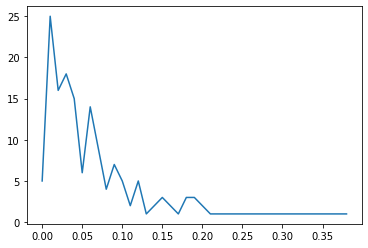

In [47]:
#creating a lineplot of the distribution of the assymetry values
for_plot = np.unique(df["assymetry"], return_counts=True)
sns.lineplot(x=for_plot[0], y=for_plot[1])

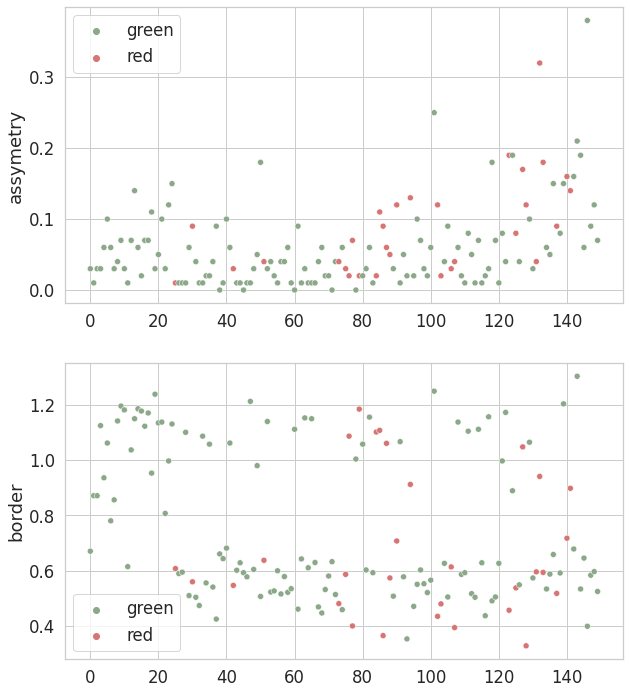

In [67]:
#create a scatterplot that shows the assymetry on the y axis 
#melanoma are colored red, benign lesions are colored green
colors1 = ['#8BA888','#D67573']
colors = ["green" if df['melanoma'][x] == 0.0 else 'red' for x in range(len(df['melanoma'])) ]

fig, axes = plt.subplots(2,1,figsize = (10,12))

for i, ax in enumerate(axes):
    xs = [i for i in range(len(df["assymetry"]))]
    ys = ["assymetry", "border"]
    sns.scatterplot(x=xs, y= df[ys[i]], hue=colors, palette=colors1, ax=ax)



Text(0.5, 1.0, 'Raincloud plot of the melanoma assymetry')

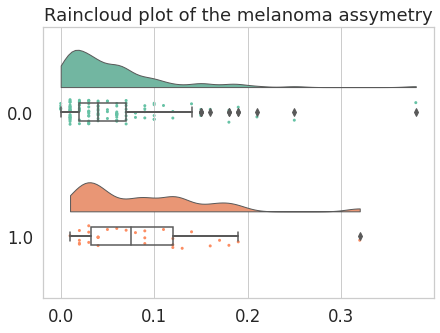

In [49]:
#create a rain cloud plot that plots the assymetry distribution for the two different groups (melanoma, benign)
sns.set(style="whitegrid",font_scale=1.5)

dx = list(df["melanoma"]); dy = list(df["assymetry"])
f, ax = plt.subplots(figsize = (7,5))
sigma = .2; ort = "h"

ax = pt.RainCloud(x = dx, y = dy, width_viol = .6, ax = ax, bw = sigma, orient= ort)
plt.title("Raincloud plot of the melanoma assymetry")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=932aa97b-f6d2-4889-8f04-d6166675cc2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>